# **Reinforcement Fine-Tuning**

*This guide is for developers and ML practitioners who have understanding of Nova Customization Tools and understanding of Nova Models in general.*

[Reinforcement fine-tuning (RFT)]() involves applying reinforcement learning techniques to existing models to enhance their reasoning capabilities. By exploring various solutions and rewarding effective strategies, RFT enables the model to make more precise decisions and better understand context. This approach results in improved performance and more accurate interpretations. 


In this guide, weʼll walk through how to apply RFT to the Nova Lite 2.0 reasoning model, using a task from the FinQA dataset 

Here’s what we’ll cover:

- **[1. Introduction](#1-setup)**
- **[2. Gathering the dataset](#2-gathering-the-dataset)**
- **[3. Evaluating the base model](#3-benchmarking-the-base-model)**
- **[4. Defining your Reward Function](#4-defining-your-grader)**
- **[5. Training](#5-training)**
- **[6. Evaluating your RFT-ed model](#6-using-your-fine-tuned-model)**


## **1. Introduction**

### Reinforcement Fine-Tuning (RFT)

Reinforcement Fine-Tuning (RFT) is a machine learning technique that improves model performance through feedback signals—measurable scores or rewards indicating response quality—rather than direct supervision with exact correct answers. Unlike traditional supervised fine-tuning that learns from input-output pairs, RFT uses reward functions to evaluate model responses and iteratively optimizes the model to maximize these rewards. This approach is particularly effective for tasks where defining the exact correct output is challenging, but you can reliably measure response quality. RFT enables models to learn complex behaviors and preferences through trial and feedback, making it ideal for applications requiring nuanced decision-making, creative problem-solving, or adherence to specific quality criteria that can be programmatically evaluated.


###  How Does It Work?

Reinforcement fine-tuning uses GRPO (Group Relative Policy Optimization), in which you start from an instruction-tuned baseline and treat each prompt like a small tournament: for a given input, you sample a handful of candidate answers from the model, score each one with the reward function, then rank them within that group. The update step simply nudges the model to make higher-scoring candidates more likely next time and lower-scoring ones less likely, while a stay-close-to-baseline constraint keeps behavior from drifting or becoming verbose or exploitative. You repeat this loop over many prompts, refreshing hard cases, tightening verifiers or judge rubrics when you see exploits, and continuously tracking task metrics.

###  When to Use RFT?

Tasks that benefit most from RFT share a few traits. They have measurable success signals even when a single correct output is hard to specify; they admit partial credit or graded quality (so better vs. worse answers can be ranked within a prompt or using a reward function); they involve multiple objectives that must be balanced (e.g., accuracy with brevity, clarity, safety, or cost); they require adherence to explicit constraints that can be programmatically checked; they operate in tool-mediated or environment-based settings where outcomes are observable (success/failure, latency, resource use); and they occur in low-label regimes where collecting gold targets is expensive but automated or rubric-based feedback is plentiful. In short, RFT shines wherever you can turn quality into a reliable scalar or ranking and want the model to preferentially amplify higher-scoring behaviors without needing exhaustive labeled targets.

Consider other methods when:

* You have plentiful, reliable labeled input-output pairs → use SFT
* The main gap is knowledge/jargon → use retrieval-augmented generation (RAG)
* Your reward signal is noisy/unreliable and can't be fixed with better rubrics/checkers → stabilize that first before RFT

###  When NOT to Use RFT?

* Avoid RFT when you can cheaply produce reliable labeled input-output pairs (SFT will be simpler, cheaper, and more stable); 
* when the gap is knowledge/jargon rather than behavior (prefer RAG); 
* when your reward signal is noisy, sparse, easy to game, or expensive/slow to compute (fix the evaluator first); 
* when baseline performance is near-zero (bootstrap with SFT before optimizing preferences); 
* when the task has deterministic schemas, strict formatting, or a single correct answer (SFT or rule-based validation works better); 
* when tight latency/cost budgets can't absorb the extra sampling/exploration RFT requires; 
* or when safety/policy constraints aren't crisply specified and enforceable in the reward.


In short: if you can point to "the right answer," do SFT; if you need new knowledge, use RAG; use RFT only after you have a solid baseline and a robust, fast, hard-to-exploit reward function.


## 2. Prerequisites and Dependencies

### Dependencies
Several python packages will need to be installed in order to execute this notebook.  Please review the packages in requirements.txt. 

botocore, boto3, sagemaker are required for the training jobs, while the other packages are used to help visualize results.

In [6]:
! pip install -r ./requirements.txt --upgrade

Looking in indexes: https://pypi.python.org/simple, https://plugin.us-east-1.prod.workshops.aws
  Using cached datasets-3.5.1-py3-none-any.whl.metadata (19 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.6.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (13 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-macosx_11_0_arm64.whl.metadata (4.9 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
INFO: pip is looking at multiple versions of pathos to determine which version is compatible with other requirements. This could take a while.
  Using cached pathos-0.3.3-py3-none-any.whl.metadata (11 kB)
  Using cached pathos-0.3.2-py3-none-any.whl.metadata (11 kB)
Using cached datase

In [ ]:
import json
import time
import os
import sagemaker
import boto3
# Get region with fallback
region = os.environ.get('AWS_DEFAULT_REGION') or boto3.Session().region_name or 'us-east-1'
sagemaker_session_bucket = None

sm = boto3.client('sagemaker', region_name='us-east-1')
sess = sagemaker.session.Session(boto_session=boto3.session.Session(), sagemaker_client=sm)

if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client("iam")
    role = iam.get_role(RoleName="sagemaker_execution_role")["Role"]["Arn"]

bucket_name = sess.default_bucket()
default_prefix = sess.default_bucket_prefix

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/dewanup/Library/Application Support/sagemaker/config.yaml
sagemaker role arn: arn:aws:iam::618100645563:role/NovaCustomizationSdkExecutionRole
sagemaker bucket: sagemaker-us-east-1-618100645563
sagemaker session region: us-east-1



## **2. Gathering the Dataset**

We'll begin by importing the dataset from Hugging Face's repository. When working with any dataset, confirming the reliability of the provided answers is essential and demands thorough evaluation. For this exercise, we'll proceed with the assumption that the dataset has been properly validated.

Next, we will split the data in train and test set so we have 2 sets to use

In [39]:
import json
import re
from typing import Dict, Any, List
from datasets import load_dataset, DatasetDict, Dataset
from random import randint

# --- Utility Functions (Provided in previous steps) ---

def clean_prefix(content):
    """Remove conversational prefixes from content."""
    prefixes = [ "SYSTEM:", "System:", "USER:", "User:", "ASSISTANT:", "Assistant:", "Bot:", "BOT:", ]
    if isinstance(content, str):
        lines = content.split("\n")
        cleaned_lines = []
        for line in lines:
            cleaned_line = line.strip()
            for prefix in prefixes:
                if cleaned_line.startswith(prefix):
                    cleaned_line = cleaned_line[len(prefix) :].strip()
                    break
            cleaned_lines.append(cleaned_line)
        return "\n".join(cleaned_lines)
    return content

# Placeholder for clean_message_list (used for final cleanup step, as per your request)
def clean_message_list(message_list):
    """Applies clean_prefix to content text within the Nova format structure."""
    if not isinstance(message_list, list):
        return message_list
    
    cleaned = []
    for item in message_list:
        if item.get("content"):
            new_content = []
            for content_item in item["content"]:
                if isinstance(content_item, dict) and "text" in content_item:
                    # Re-apply cleaning here if necessary
                    content_item["text"] = clean_prefix(content_item["text"])
                    new_content.append(content_item)
            item["content"] = new_content
            cleaned.append(item)
    return cleaned

# --- FinQA Data Processing Functions ---

def finqa_to_standard_format(example: Dict[str, Any]) -> Dict[str, Any]:
    """Converts a FinQA example into the intermediate standard message list format."""
    
    # 1. Format Table for prompt
    table_data = example.get('table', [])
    table_str = ""
    # ... (Table formatting logic) ...
    if table_data and isinstance(table_data, list) and table_data[0]:
        header = table_data[0]
        rows = table_data[1:]
        table_str += "| " + " | ".join(map(str, header)) + " |\n"
        table_str += "| " + " | ".join(["---"] * len(header)) + " |\n"
        for row in rows:
            table_str += "| " + " | ".join(map(str, row)) + " |\n"
    else:
        table_str = "No structured table data provided."
    
    user_prompt = f"""Given the following financial context and table data:

---
CONTEXT: {example['pre_text']}

TABLE:
{table_str}

---
QUESTION: {example['question']}

Provide your answer in the following format:\nANSWER: [your answer here]"""

    assistant_response = example['answer']

    messages: List[Dict[str, Any]] = [
        {"role": "system", "content": "You are a specialized financial analysis AI. Your task is to look at the provided CONTEXT and QUESTION and answer approprietly"},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": assistant_response}
    ]
    return {"messages": messages}

def convert_to_nova_sft_format(example: Dict[str, Any]) -> Dict[str, Any]:
    """Converts the standard message list into the Nova format structure."""
    standard_messages = example.get("messages", [])
    if not standard_messages:
        return {"system": [], "messages": []}

    nova_system = []
    nova_messages = []

    for i, msg in enumerate(standard_messages):
        role = msg["role"]
        content = msg["content"]
        cleaned_content = clean_prefix(content)
        
        # Required Nova structure: content is [{"text": ...}]
        nova_content_struct = [{"text": cleaned_content}]
        
        if role == "system" and i == 0:
            nova_system = nova_content_struct
        else:
            nova_messages.append({"role": role, "content": nova_content_struct})
            
    # Return the new keys
    return {"system": nova_system, "messages": nova_messages}

def convert_to_nova_rft_format(example: Dict[str, Any]) -> Dict[str, Any]:
    """Converts the standard message list into the Nova RFT format structure."""
    standard_messages = example.get("messages", [])
    if not standard_messages:
        return {"messages": [], "reference_answer": {"answer": ""}}
    
    nova_messages = []
    reference_answer = ""
    
    for msg in standard_messages:
        role = msg["role"]
        content = msg["content"]
        cleaned_content = clean_prefix(content)
        
        if role == "assistant":
            # Assistant messages go into reference_answer
            reference_answer = cleaned_content
        else:
            # User and system messages stay in messages array
            nova_messages.append({
                "role": role,
                "content": cleaned_content
            })
    
    # Build the result
    result = {
        "messages": nova_messages,
        "reference_answer": {"answer": reference_answer}
    }
    
    # Preserve any additional fields from the original example
    for key, value in example.items():
        if key != "messages":
            result[key] = value
    
    return result


In [40]:
print("1. Loading FinQA DatasetDict (all splits)...")
dataset_dict = load_dataset("ibm-research/finqa", trust_remote_code=True)
final_dataset_dict = DatasetDict()

# Loop through each split (train, validation, test)
for split_name in dataset_dict.keys():
    print(f"\nProcessing split: {split_name}...")
    
    current_dataset = dataset_dict[split_name]
    initial_features = list(current_dataset.features.keys())
    
    # --- Step 1: Convert FinQA structure to standard message list ---
    processed_std = current_dataset.map(
        finqa_to_standard_format, 
        remove_columns=initial_features
    )
    
    # --- Step 2: Convert to appropriate Nova format based on split ---
    if split_name == "test":
        # Test split: Use flat string format (system/query/response)
        processed_nova = processed_std.map(convert_to_nova_rft_format)
        
        # Convert to pandas for any final cleanup if needed
        processed_df = processed_nova.to_pandas()
        
        # Convert back to Dataset
        final_dataset = Dataset.from_pandas(processed_df)
        
    else:
        # Train/Validation splits: Use nested Nova format (system array + messages array)
        processed_nova = processed_std.map(convert_to_nova_rft_format)
        
        # --- Step 3: Apply cleanup and finalize structure ---
        # Convert to pandas to apply column-wise function (clean_message_list)
        processed_df = processed_nova.to_pandas()
        
        # Apply the cleaning function to the 'messages' column
        # Note: 'system' is separate in Nova format, so clean_message_list only applies to 'messages'.
        processed_df["messages"] = processed_df["messages"].apply(clean_message_list)
        
        # Convert back to Dataset
        final_dataset = Dataset.from_pandas(processed_df)
    
    # Assign the final processed split to the DatasetDict
    final_dataset_dict[split_name] = final_dataset
    
    # Print example for verification
    if final_dataset.num_rows > 0:
        rand_index = randint(0, final_dataset.num_rows - 1)
        print(f"\nExample from {split_name} split (Row {rand_index}):")
        print(json.dumps(final_dataset[rand_index], indent=2))

print("\n--- FINAL RESULT ---")
print(final_dataset_dict)


1. Loading FinQA DatasetDict (all splits)...

Processing split: train...


Map: 100%|██████████| 6251/6251 [00:00<00:00, 20419.43 examples/s]



Example from train split (Row 5660):
{
  "messages": [
    {
      "content": "You are a specialized financial analysis AI. Your task is to look at the provided CONTEXT and QUESTION and answer approprietly",
      "role": "system"
    },
    {
      "content": "Given the following financial context and table data:\n\n---\nCONTEXT: ['baker hughes , a ge company notes to consolidated and combined financial statements bhge 2017 form 10-k | 85 the total intrinsic value of rsus ( defined as the value of the shares awarded at the current market price ) vested and outstanding in 2017 was $ 17 million and $ 38 million , respectively .', 'the total fair value of rsus vested in 2017 was $ 19 million .', 'as of december 31 , 2017 , there was $ 98 million of total unrecognized compensation cost related to unvested rsus , which is expected to be recognized over a weighted average period of 2.5 years .', 'note 12 .', 'equity common stock we are authorized to issue 2 billion shares of class a common

Map: 100%|██████████| 883/883 [00:00<00:00, 21598.31 examples/s]



Example from validation split (Row 148):
{
  "messages": [
    {
      "content": "You are a specialized financial analysis AI. Your task is to look at the provided CONTEXT and QUESTION and answer approprietly",
      "role": "system"
    },
    {
      "content": "Given the following financial context and table data:\n\n---\nCONTEXT: ['management 2019s discussion and analysis of financial condition and results of operations 2013 ( continued ) ( amounts in millions , except per share amounts ) liquidity and capital resources cash flow overview the following tables summarize key financial data relating to our liquidity , capital resources and uses of capital. .']\n\nTABLE:\n| cash flow data | years ended december 31 , 2015 | years ended december 31 , 2014 | years ended december 31 , 2013 |\n| --- | --- | --- | --- |\n| net income adjusted to reconcile net income to net cashprovided by operating activities1 | $ 848.2 | $ 831.2 | $ 598.4 |\n| net cash used in working capital2 | -117.5 ( 

Map: 100%|██████████| 1147/1147 [00:00<00:00, 21948.49 examples/s]


Example from test split (Row 1091):
{
  "messages": [
    {
      "content": "You are a specialized financial analysis AI. Your task is to look at the provided CONTEXT and QUESTION and answer approprietly",
      "role": "system"
    },
    {
      "content": "Given the following financial context and table data:\n\n---\nCONTEXT: ['table of contents hologic , inc .', 'notes to consolidated financial statements ( continued ) ( in thousands , except per share data ) cytyc , headquartered in marlborough , massachusetts , is a diversified diagnostic and medical device company that designs , develops , manufactures , and markets innovative and clinically effective diagnostics and surgical products .', 'cytyc products cover a range of cancer and women 2019s health applications , including cervical cancer screening , prenatal diagnostics , treatment of excessive menstrual bleeding and radiation treatment of early-stage breast cancer .', 'upon the close of the merger , cytyc shareholders rece

In [41]:
from datasets import Dataset, DatasetDict
from random import randint

# 1. Define the datasets using the correct keys from final_dataset_dict
test_dataset = final_dataset_dict["test"]
val_dataset = final_dataset_dict["validation"]
train_dataset = final_dataset_dict["train"]

rand_index = randint(0, len(test_dataset) - 1)
print(f"Sampling a random example from test_dataset (Index {rand_index}):")
print(test_dataset[rand_index])

# choose a small number of samples for the training job
N_SAMPLES = 100

# 2. Get the first N_SAMPLES from each split
# Note: If a split has fewer than 100 samples, it will return all available samples.
test_subset = test_dataset.select(range(min(N_SAMPLES, len(test_dataset))))
val_subset = val_dataset.select(range(min(N_SAMPLES, len(val_dataset))))
train_subset = train_dataset.select(range(min(N_SAMPLES, len(train_dataset))))

# 3. Verification and Output
print(f"Original Test Size: {len(test_dataset)}")
print(f"Subset Test Size: {len(test_subset)}")
print(f"Subset Train Size: {len(train_subset)}")
print(f"Subset Validation Size: {len(val_subset)}")
print("-" * 30)



Sampling a random example from test_dataset (Index 322):
{'messages': [{'content': 'You are a specialized financial analysis AI. Your task is to look at the provided CONTEXT and QUESTION and answer approprietly', 'role': 'system'}, {'content': "Given the following financial context and table data:\n\n---\nCONTEXT: ['our intangible assets are amortized over their estimated useful lives of 1 to 13 years as shown in the table below .', 'amortization is based on the pattern in which the economic benefits of the intangible asset will be consumed .', 'weighted average useful life ( years ) .']\n\nTABLE:\n|  | weighted average useful life ( years ) |\n| --- | --- |\n| purchased technology | 4 |\n| localization | 1 |\n| trademarks | 5 |\n| customer contracts and relationships | 6 |\n| other intangibles | 3 |\n\n\n---\nQUESTION: is the weighted average useful life ( years ) for purchased technology greater than localization?\n\nProvide your answer in the following format:\nANSWER: [your answer 

In [42]:
import boto3
import shutil


s3_client = boto3.client('s3')

# save train_dataset to s3 using our SageMaker session
if default_prefix:
    input_path = f"{default_prefix}/datasets/nova-rft"
else:
    input_path = f"datasets/nova-rft"

train_dataset_s3_path = f"s3://{bucket_name}/{input_path}/train/dataset.jsonl"
val_dataset_s3_path = f"s3://{bucket_name}/{input_path}/val/dataset.jsonl"
test_dataset_s3_path = f"s3://{bucket_name}/{input_path}/test/gen_qa.jsonl"

In [43]:
import os
import shutil

TRAIN_FULL_PATH = "./data/train/subset_train.jsonl"
VAL_FULL_PATH = "./data/val/subset_validation.jsonl"
TEST_FULL_PATH = "./data/test/subset_test.json" 


# 1. Save datasets to local files
print("1. Creating local directories and saving datasets...")
os.makedirs("./data/train", exist_ok=True)
os.makedirs("./data/val", exist_ok=True)
os.makedirs("./data/test", exist_ok=True) 

# Save the splits from the final_dataset_dict subsets
print(f"Saving train split (first {len(train_subset)} samples) to {TRAIN_FULL_PATH}")
# Use the SUBSET dataset object to save
train_subset.to_json(TRAIN_FULL_PATH, orient="records", lines=True)

# Note: The FinQA validation split is stored under the key "validation"
print(f"Saving validation split (first {len(val_subset)} samples) to {VAL_FULL_PATH}")
# Use the SUBSET dataset object to save
val_subset.to_json(VAL_FULL_PATH, orient="records", lines=True)

print(f"Saving test split (first {len(test_subset)} samples) to {TEST_FULL_PATH}")
# Note: Retaining the user's original call signature for test (without orient/lines args)
# Use the SUBSET dataset object to save
test_subset.to_json(TEST_FULL_PATH)


# 2. Upload local files to S3
print("\n2. Uploading datasets to S3 using s3_client...")

# Use the FULL local paths for upload_file
s3_client.upload_file(
    TRAIN_FULL_PATH, bucket_name, f"{input_path}/train/dataset.jsonl"
)

s3_client.upload_file(
    VAL_FULL_PATH, bucket_name, f"{input_path}/val/dataset.jsonl"
)

s3_client.upload_file(
    TEST_FULL_PATH, bucket_name, f"{input_path}/test/gen_qa.jsonl"
)


# 3. Cleanup local files
print("\n3. Cleaning up local data directory...")
try:
    shutil.rmtree("./data")
except OSError as e:
    # Handle case where directory might not exist or permissions fail
    print(f"Error cleaning up local directory: {e}")


# 4. Print confirmation
print("\nDatasets uploaded successfully:")
print(f"Training data uploaded to: {train_dataset_s3_path}")
print(f"Validation data uploaded to: {val_dataset_s3_path}")
print(f"Test data uploaded to: {test_dataset_s3_path}")
%store test_dataset_s3_path


1. Creating local directories and saving datasets...
Saving train split (first 100 samples) to ./data/train/subset_train.jsonl


Creating json from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 35.75ba/s]


Saving validation split (first 100 samples) to ./data/val/subset_validation.jsonl


Creating json from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 428.25ba/s]


Saving test split (first 100 samples) to ./data/test/subset_test.json


Creating json from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 402.41ba/s]


2. Uploading datasets to S3 using s3_client...



3. Cleaning up local data directory...

Datasets uploaded successfully:
Training data uploaded to: s3://sagemaker-us-east-1-618100645563/datasets/nova-rft/train/dataset.jsonl
Validation data uploaded to: s3://sagemaker-us-east-1-618100645563/datasets/nova-rft/val/dataset.jsonl
Test data uploaded to: s3://sagemaker-us-east-1-618100645563/datasets/nova-rft/test/gen_qa.jsonl
Stored 'test_dataset_s3_path' (str)


## 3. Preparing the Reward Function

#### Bring your own code packaged in Lambda Function

Bring Your Own code that is package in a Lambda Function following below schema as mentioned. In this case, Reward functions are implemented as AWS Lambda functions that evaluate model responses and return numerical scores. The Lambda function receives messages and ground truth in the OpenAI format and must return scores as a dictionary. For the basic example no additional Lambda layers are required.

##### Input Payload for the lambda function

RFT internally append the assistant turn (generated response) to the last turn of messages field and a unique id . The payload to the reward lambda is same as the output of the generated response.


```json
[{  
   "id": "str",
    "messages": [
        {
            "role": "system",
            "content": < pass through as is from input data point>
        }
        {
            "role": "user",
            "content": < pass through as is from input data point>
        },
        {
            "role": "assistant",
            "content": <models prediction are appended >
        }
    ],            
    # Following section will be same as your training dataset sample
    "reference_answer": {
        <pass through as is from the input data point>
    }
}]
```


##### Output Payload from the lambda function

```json
{
            "id": str,                              # Same id as input sample
            "aggregate_reward_score": float,        # Overall score for the sample(Numerical)
            "metrics_list": [                       # OPTIONAL: Component-wise scores
                {
                    "name": str,                    # Name of the component score
                    "value": float,                 # Value of the component score
                    "type": str                     # "Reward" or "Metric"
                }
            ]
        }
```

#### Build your reward function > Step 1: Code your lambda reward function first

In [5]:
%%writefile rft_finqa_lambda.py

from typing import List
import json
import random

from dataclasses import asdict, dataclass

import re
from typing import Optional


def extract_number(text: str) -> Optional[float]:
    """Extract numerical answer from text, prioritizing structured format."""
    # First, try to extract from structured format: ANSWER: <number>
    # Handle various formats: ANSWER: 66.65%, ANSWER: [66.65%], ANSWER: **66.65%**
    answer_match = re.search(r'ANSWER:\s*[\[\*]*([\d,.-]+%?)[\]\*]*', text, re.IGNORECASE)
    if answer_match:
        num_str = answer_match.group(1).replace('$', '').replace('%', '').replace(',', '').strip()
        try:
            return float(num_str)
        except ValueError:
            pass
    
    # Fallback: Try to find numbers anywhere in text
    # Try to find numbers (including decimals, percentages, negatives, commas)
    number_patterns = [
        r'-?\d{1,3}(?:,\d{3})+(?:\.\d+)?%?',  # Number with commas (e.g., 25,000)
        r'-?\d+\.?\d*%?',  # Basic number with optional decimal and percentage
        r'\$?\s*-?\d+\.?\d*',  # Number with optional dollar sign
    ]
    
    for pattern in number_patterns:
        matches = re.findall(pattern, text)
        if matches:
            # Take the last number found
            num_str = matches[-1].replace('$', '').replace('%', '').replace(',', '').strip()
            try:
                return float(num_str)
            except ValueError:
                continue
    
    return None


def normalize_number(num: float, tolerance: float = 0.01) -> float:
    """Normalize number for comparison."""
    return round(num, 2)


def compute_score(
    solution_str: str,
    ground_truth: str,
    format_score: float = 0.0,
    score: float = 1.0,
    data_source: str = 'finqa',
    extra_info: Optional[dict] = None
) -> float:
    """FinQA scoring function for numerical and yes/no answers."""
    gt_answer = ground_truth.get("answer", ground_truth)
    gt_str = str(gt_answer).lower().strip()
    
    # Check if ground truth is yes/no
    if gt_str in ['yes', 'no']:
        # Extract answer from structured format
        answer_match = re.search(r'ANSWER:\s*(\w+)', solution_str, re.IGNORECASE)
        if answer_match:
            predicted_answer = answer_match.group(1).lower().strip()
            if predicted_answer == gt_str:
                return score
        return 0.0
    
    # Handle numerical answers
    predicted_num = extract_number(solution_str)
    if predicted_num is None:
        return 0.0
    
    # Try to parse ground truth as number
    try:
        gt_num = float(str(gt_answer).replace(',', '').replace('$', '').replace('%', ''))
    except (ValueError, AttributeError):
        return 0.0
    
    # Handle decimal vs percentage mismatch BEFORE normalizing (e.g., 0.098 vs 9.8)
    # If one is ~100x the other, try converting decimal to percentage
    if abs(predicted_num * 100 - gt_num) < abs(predicted_num - gt_num):
        predicted_num = predicted_num * 100
    elif abs(predicted_num - gt_num * 100) < abs(predicted_num - gt_num):
        gt_num = gt_num * 100
    
    # Normalize both numbers after conversion
    pred_normalized = normalize_number(predicted_num)
    gt_normalized = normalize_number(gt_num)
    
    # Exact match
    if pred_normalized == gt_normalized:
        return score
    
    # Check absolute difference with adaptive tolerance
    abs_diff = abs(pred_normalized - gt_normalized)
    
    # For small values (< 2), use tighter absolute tolerance (0.1)
    # For larger values, use 0.9
    abs_tolerance = 0.1 if abs(gt_normalized) < 2 else 0.9
    
    if abs_diff < abs_tolerance:
        return score * 0.95
    
    # Check relative error for larger values
    relative_error = abs_diff / max(abs(gt_normalized), 1e-10)
    if relative_error < 0.01:  # 1% tolerance
        return score * 0.95
    
    return format_score

@dataclass
class RewardOutput:
    """Reward service."""

    id: str
    aggregate_reward_score: float

def lambda_handler(event, context):

    scores: List[RewardOutput] = []

    samples = event

    for sample in samples:
        # Extract the ground truth key. In the current dataset it's answer
        print("Sample: ", json.dumps(sample, indent=2))
        ground_truth = sample["reference_answer"]
        
        idx = "no id"
        # print(sample)
        if not "id" in sample:
            print(f"ID is None/empty for sample: {sample}")
        else:
            idx = sample["id"]

        ro = RewardOutput(id=idx, aggregate_reward_score=0.0)

        if not "messages" in sample:
            print(f"Messages is None/empty for id: {idx}")
            scores.append(RewardOutput(id="0", aggregate_reward_score=0.0))
            continue
        
        # Extract answer from ground truth dict
        if ground_truth is None:
            print(f"No answer found in ground truth for id: {idx}")
            scores.append(RewardOutput(id="0", aggregate_reward_score=0.0))
            continue
        
        # Get completion from last message (assistant message)
        last_message = sample["messages"][-1]
        completion_text = last_message["content"]
        
        if last_message["role"] not in ["assistant", "nova_assistant"]:
            print(f"Last message is not from assistant for id: {idx}")
            scores.append(RewardOutput(id="0", aggregate_reward_score=0.0))
            continue

        if not "content" in last_message:
            print(f"Completion text is empty for id: {idx}")
            scores.append(RewardOutput(id="0", aggregate_reward_score=0.0))
            continue

        random_score = compute_score(solution_str=completion_text, ground_truth=ground_truth)
        ro = RewardOutput(id=idx, aggregate_reward_score=random_score)

        print(f"Response for id: {idx} is {ro}")
        scores.append(ro)

    return [asdict(score) for score in scores]

Overwriting rft_finqa_lambda.py


In [6]:
from utils.lambda_deployer import create_lambda_function
from utils.lambda_role_helper import get_or_create_lambda_role
from utils import add_lambda_invoke_permission_to_customization_role

#### Build your reward function > Step 2: Next, lets deploy this reward function script to Lambda function

In [7]:
# Deploy your Lambda function
role_arn = get_or_create_lambda_role(
    role_name="finqa_reward_function_lambda_role",
    managed_policies=[
        "arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole",
        "arn:aws:iam::aws:policy/AmazonBedrockFullAccess"
    ]
)
time.sleep(15)
reward_lambda_arn = create_lambda_function(
    lambda_script_path="rft_finqa_lambda.py",
    function_name="finqa-reward-fn",
    role_arn=role_arn,
    skip_if_exists=True
)

print(f"Lambda ARN: {reward_lambda_arn}")

🔐 Creating IAM role: finqa_reward_function_lambda_role
✅ Role created: arn:aws:iam::618100645563:role/finqa_reward_function_lambda_role
📎 Attaching policy: arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole
📎 Attaching policy: arn:aws:iam::aws:policy/AmazonBedrockFullAccess
✅ All policies attached successfully!
⏳ Note: Wait 10-15 seconds before using this role with Lambda
📦 Found requirements.txt - Note: You may need to include dependencies as a Lambda layer
🚀 Creating Lambda function: finqa-reward-fn
✅ Lambda function created successfully!
   ARN: arn:aws:lambda:us-east-1:618100645563:function:finqa-reward-fn
   Runtime: python3.11
   Handler: lambda_function.lambda_handler
   Timeout: 300s
   Memory: 512MB
Lambda ARN: arn:aws:lambda:us-east-1:618100645563:function:finqa-reward-fn


#### Build your reward function > Step 3: Lets attach Lambda Invocation Polciy to our SageMaker Role which will be used for RFT

One more thing to note, is to make sure our SageMaker Execution role has access to call this Lambda, so lets go ahead and add that execution policy to our SageMaker Execution Role

In [14]:
add_lambda_invoke_permission_to_customization_role(
    role_arn=role,
    lambda_function_arn=reward_lambda_arn
)

📝 Adding Lambda invoke permission to customization role
   Role ARN: arn:aws:iam::618100645563:role/NovaCustomizationSdkExecutionRole
   Lambda ARN: arn:aws:lambda:us-east-1:618100645563:function:finqa-reward-fn
✅ Lambda invoke permission added successfully!
   Policy name: LambdaInvokePolicy


'LambdaInvokePolicy'


### Configure Evaluation Recipe

The recipe YAML defines the complete evaluation pipeline: model selection, inference parameters, and reward function configuration. Key settings include model_name_or_path for model name/path to use and the Lambda ARN for reward function calculation.


#### 🚀 Lets Launch Now

Now, we can kick off 2 runs 
1. Base Model Evaluation using our reward function as evaluator
2. Kick off RFT as well using reward function

In [2]:
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput

def rft_launcher(train_S3_uri, reward_lambda_arn):
    instance_type = "ml.p5.48xlarge"
    instance_count = 4
    recipe = "fine-tuning/nova/nova_2_0/nova_lite/RFT/nova_lite_v2_smtj_p5_p5en_gpu_lora_rft"
    image_uri = "708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-fine-tune-repo:SM-TJ-RFT-V2-latest"
    model_id = "nova-lite-2/prod"
    job_name = f"rft-lora-{model_id.split('/')[0].replace('.', '-')}"
    if default_prefix:
        output_path = f"s3://{bucket_name}/{default_prefix}/{job_name}"
    else:
        output_path = f"s3://{bucket_name}/{job_name}"

    recipe_overrides = {
        "run": {
            "data_s3_path": train_S3_uri,
            "reward_lambda_arn": reward_lambda_arn,  
        },
        "training_config": {
            "rollout": {
                "rewards": {
                    "api_endpoint": {
                        "lambda_arn": reward_lambda_arn
                    }
                }
            }
        }
    }

    estimator = PyTorch(
        output_path=output_path,
        base_job_name=job_name,
        role=role,
        disable_profiler=True,
        debugger_hook_config=False,
        instance_count=instance_count,
        instance_type=instance_type,
        recipe_overrides=recipe_overrides,
        training_recipe=recipe,
        sagemaker_session=sess,
        image_uri=image_uri
    )
    train_input = TrainingInput(
        s3_data =train_S3_uri,
        distribution="FullyReplicated"
    )
    estimator.fit(inputs={"train": train_input}, wait=False)
    training_job_name = estimator.latest_training_job.name
    print('Training Job Name:  {}'.format(training_job_name))
    return training_job_name

def rft_eval_launcher(test_S3_uri, reward_lambda_arn, chkpt_uri=None):
    instance_type = "ml.p5.48xlarge"
    instance_count = 1
    recipe = "evaluation/nova/nova_2_0/nova_lite/nova_lite_2_0_p5_48xl_gpu_rft_eval"
    image_uri = "708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-evaluation-repo:SM-TJ-Eval-V2-latest"
    model_id = "nova-lite-2/prod"
    job_name = f"rft-eval-{model_id.split('/')[0].replace('.', '-')}"
    if default_prefix:
        output_path = f"s3://{bucket_name}/{default_prefix}/{job_name}"
    else:
        output_path = f"s3://{bucket_name}/{job_name}"
    recipe_overrides = {
        "rl_env": {
            "reward_lambda_arn": reward_lambda_arn
        },
        "run":{
            "data_s3_path": test_S3_uri
        }
    }
    if chkpt_uri is not None:
        recipe_overrides['run']['model_name_or_path'] = chkpt_uri

    estimator = PyTorch(
        output_path=output_path,
        base_job_name=job_name,
        role=role,
        disable_profiler=True,
        debugger_hook_config=False,
        instance_count=instance_count,
        instance_type=instance_type,
        recipe_overrides=recipe_overrides,
        training_recipe=recipe,
        sagemaker_session=sess,
        image_uri=image_uri
    )
    test_input = TrainingInput(
        s3_data=test_S3_uri,
        distribution="FullyReplicated"
    )
    estimator.fit(inputs={"train": test_input}, wait=False)
    eval_job_name = estimator.latest_training_job.name
    print('Evaluation Job Name:  {}'.format(eval_job_name))
    return eval_job_name


In [ ]:
rft_training_job =rft_launcher(train_dataset_s3_path, reward_lambda_arn)

Cloning into '/var/folders/rs/nxh2tnrd6d5gmrtsmx2_ybzh0000gr/T/launcher_0s69lurp'...
Using instance_count argument to estimator to set number of nodes. Ignoring run -> replicas in recipe.
INFO:sagemaker:Creating training-job with name: rft-lora-nova-lite-2-2026-02-08-01-36-54-235


Training Job Name:  rft-lora-nova-lite-2-2026-02-08-01-36-54-235


In [48]:
rft_base_eval_job =rft_eval_launcher(test_dataset_s3_path, reward_lambda_arn)

Cloning into '/var/folders/rs/nxh2tnrd6d5gmrtsmx2_ybzh0000gr/T/launcher_ttqbnrdd'...
INFO:sagemaker:Remote debugging, profiler and debugger hooks are disabled for Nova recipes.
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: rft-eval-nova-lite-2-2026-02-07-23-38-28-417


Evaluation Job Name:  rft-eval-nova-lite-2-2026-02-07-23-38-28-417


##### Now, lets unpack our RFT run output to find metrics along with checkpoint info in `manifest.json`

In [ ]:
from utils.s3_tar_downloader import download_and_unpack_s3_tar
from utils.plot_training_metrics import (
    plot_step_wise_training_metrics,
    plot_training_metrics_combined
)


rft_training_job = "< TRAINING JOB NAME > "
response = sm.describe_training_job(
            TrainingJobName=rft_training_job
        )
rft_output_s3_uri = response['ModelArtifacts']['S3ModelArtifacts']
rft_output_s3_uri = rft_output_s3_uri.replace("model.tar.gz", "output.tar.gz")

files = download_and_unpack_s3_tar(
    bucket_name = bucket_name,
    s3_key=rft_output_s3_uri,
    extract_to='./post-rft'
)
with open('./post-rft/manifest.json', 'r') as file:
    chkpt_info = json.load(file)['checkpoint_s3_bucket']


### Plot the Metrics

The Key metrics to look are:
- **Critic Reward Distribution Metrics**: These help in finding how the reward shape looks like and if they are on a path of gradual increase.

`critic/rewards/mean`, `critic/rewards/max`, `critic/rewards/min`

- **Model Exploratory Behavior Metrics**: This metrics help us in understanding the exploratory nature of the model. The higher entropy indicates model higher the policy variuation and more models ability to exploring new paths. 

`actor/entropy`: Policy variation (higher = more exploratory)

Loaded training metrics with 20 steps
Columns: ['step_number', 'epoch_number', 'train_reward_mean', 'train_episode_length_mean', 'policy_entropy', 'gradient_norm', 'mean_advantage', 'min_advantage', 'max_advantage']

Plot saved to: training_metrics_selected.png

TRAINING METRICS SUMMARY

Train Reward Mean:
  Initial: 0.324218
  Final:   0.529897
  Mean:    0.475248
  Std:     0.061144
  Min:     0.324218
  Max:     0.529897


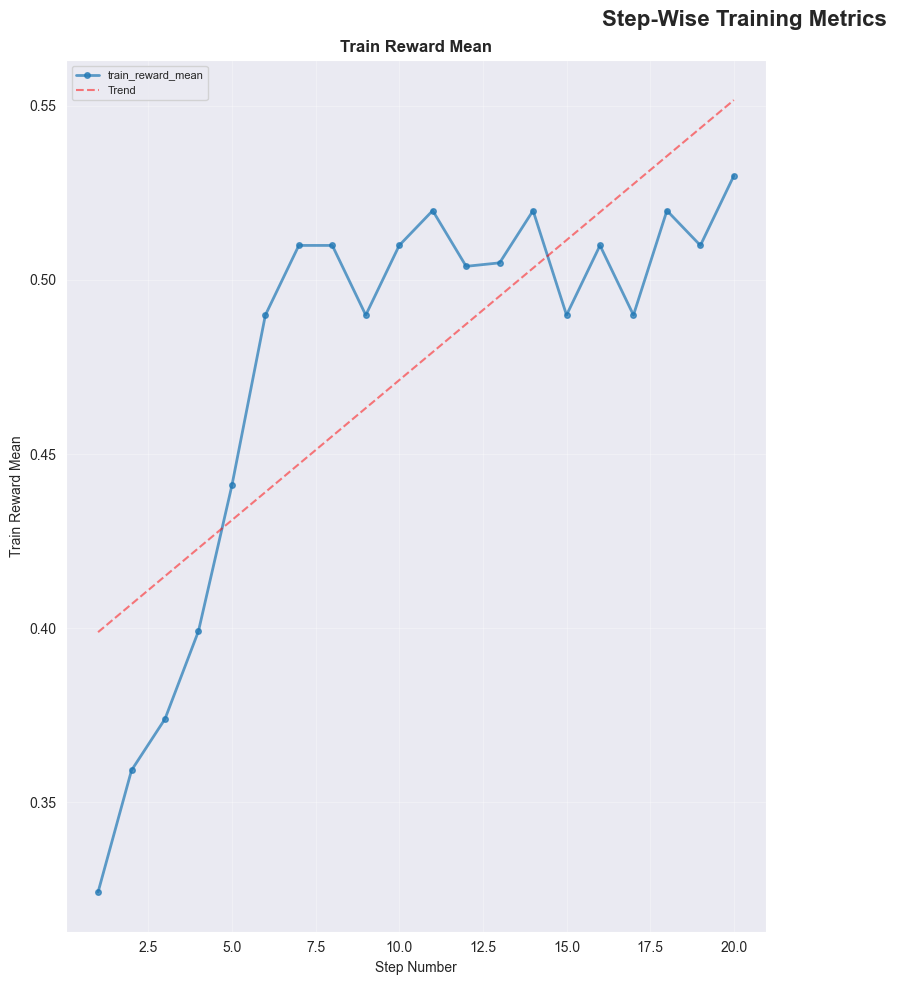

In [42]:

plot_step_wise_training_metrics(
        csv_path='post-rft/step_wise_training_metrics.csv',
        output_path='training_metrics_selected.png',
        metrics=['train_reward_mean']
)

### Launch Evaluation on top of the RFT checkpoint 

In [ ]:
# test_S3_uri = "s3://sagemaker-us-east-1-618100645563/datasets/nova-rft/test/gen_qa.jsonl"
# reward_lambda_arn = "arn:aws:lambda:us-east-1:618100645563:function:finqa-reward-fn"

In [14]:
post_rft_eval_job =rft_eval_launcher(test_S3_uri, reward_lambda_arn, chkpt_info)

Cloning into '/var/folders/rs/nxh2tnrd6d5gmrtsmx2_ybzh0000gr/T/launcher_m61fhzmf'...
Using instance_count argument to estimator to set number of nodes. Ignoring run -> replicas in recipe.
INFO:sagemaker:Creating training-job with name: rft-eval-nova-lite-2-2026-02-10-00-01-24-025


Evaluation Job Name:  rft-eval-nova-lite-2-2026-02-10-00-01-24-025


### Compare Evaluation Metrics Pre and Post RFT

Now lets look at the evaluation metrics from base model and post-RFT to compare and contrast

In [ ]:
rft_base_eval_job= "<EVAL JOB NAME>"
response = sm.describe_training_job(
            TrainingJobName=rft_base_eval_job
        )
rft_base_eval_output_s3_uri = response['ModelArtifacts']['S3ModelArtifacts']
rft_base_eval_output_s3_uri = rft_base_eval_output_s3_uri.replace("model.tar.gz", "output.tar.gz")

files = download_and_unpack_s3_tar(
    bucket_name = bucket_name,
    s3_key=rft_base_eval_output_s3_uri,
    extract_to='./pre-rft-eval'
)

from pathlib import Path
folder = Path('./post-rft-eval')
json_files = list(folder.glob('*/*/*.json'))
results_file = json_files[0]
print(results_file)

with open(results_file, 'r', encoding='utf-8') as f:
    content = f.read()
    results_data_base =  json.loads(content)


Downloaded 342,848 bytes

Extracting to: ./pre-rft-eval
Found 10 items in archive

ARCHIVE CONTENTS:
[DIR ]              bytes  nova-lite-v2-rft-eval-job
[DIR ]              bytes  nova-lite-v2-rft-eval-job/tensorboard_results
[DIR ]              bytes  nova-lite-v2-rft-eval-job/tensorboard_results/eval
[FILE]        1,437 bytes  nova-lite-v2-rft-eval-job/tensorboard_results/eval/events.out.tfevents.1770508399.ip-172-16-224-182.ec2.internal
[DIR ]              bytes  nova-lite-v2-rft-eval-job/eval_results
[FILE]        2,382 bytes  nova-lite-v2-rft-eval-job/eval_results/results_2026-02-07T23-53-19.562152+00-00.json
[DIR ]              bytes  nova-lite-v2-rft-eval-job/eval_results/details
[DIR ]              bytes  nova-lite-v2-rft-eval-job/eval_results/details/model
[DIR ]              bytes  nova-lite-v2-rft-eval-job/eval_results/details/model/2026-02-07T23-53-19.562152+00-00
[FILE]      395,711 bytes  nova-lite-v2-rft-eval-job/eval_results/details/model/2026-02-07T23-53-19.562152+00-

In [ ]:
post_rft_eval_job = "<EVAL JOB NAME>"
response = sm.describe_training_job(
            TrainingJobName=post_rft_eval_job
        )
post_rft_eval_output_s3_uri = response['ModelArtifacts']['S3ModelArtifacts']
post_rft_eval_output_s3_uri = post_rft_eval_output_s3_uri.replace("model.tar.gz", "output.tar.gz")

files = download_and_unpack_s3_tar(
    bucket_name = bucket_name,
    s3_key=post_rft_eval_output_s3_uri,
    extract_to='./post-rft-eval'
)

folder = Path('./post-rft-eval')
json_files = list(folder.glob('*/*/*.json'))
results_file = json_files[0]

with open(results_file, 'r', encoding='utf-8') as f:
    content = f.read()
    results_data_post_rft =  json.loads(content)


Downloaded 351,730 bytes

Extracting to: ./post-rft-eval
Found 10 items in archive

ARCHIVE CONTENTS:
[DIR ]              bytes  nova-lite-v2-rft-eval-job
[DIR ]              bytes  nova-lite-v2-rft-eval-job/tensorboard_results
[DIR ]              bytes  nova-lite-v2-rft-eval-job/tensorboard_results/eval
[FILE]        1,476 bytes  nova-lite-v2-rft-eval-job/tensorboard_results/eval/events.out.tfevents.1770683426.ip-172-16-209-210.ec2.internal
[DIR ]              bytes  nova-lite-v2-rft-eval-job/eval_results
[DIR ]              bytes  nova-lite-v2-rft-eval-job/eval_results/details
[DIR ]              bytes  nova-lite-v2-rft-eval-job/eval_results/details/model
[DIR ]              bytes  nova-lite-v2-rft-eval-job/eval_results/details/model/2026-02-10T00-30-26.256621+00-00
[FILE]      414,427 bytes  nova-lite-v2-rft-eval-job/eval_results/details/model/2026-02-10T00-30-26.256621+00-00/details_custom|rft_eval_rft_eval|0_2026-02-10T00-30-26.256621+00-00.parquet
[FILE]        2,417 bytes  nova-

In [27]:
from pathlib import Path
folder = Path('./pre-rft-eval')
json_files = list(folder.glob('*/*/*.json'))
results_file = json_files[0]

with open(results_file, 'r', encoding='utf-8') as f:
    content = f.read()
    pre_results_data =  json.loads(content)
print("✅ Results File Loaded")



from pathlib import Path
folder = Path('./post-rft-eval')
json_files = list(folder.glob('*/*/*.json'))
results_file = json_files[0]

with open(results_file, 'r', encoding='utf-8') as f:
    content = f.read()
    post_results_data =  json.loads(content)
print("✅ Results File Loaded")


✅ Results File Loaded
✅ Results File Loaded


In [36]:
base_results = pre_results_data['results']['custom|rft_eval_rft_eval|0']

base_eval_results = {
'model_conf': "Base",
 'overall_score': base_results['lambda_reward_score']
}
import pandas as pd

base_row = pd.DataFrame([base_eval_results])
# results_df= pd.concat([past_rsults_df, new_row], ignore_index=True)


rft_results = post_results_data['results']['custom|rft_eval_rft_eval|0']

rft_eval_results = {
'model_conf': "RFT wirh 20 steps",
 'overall_score': rft_results['lambda_reward_score']
}
rft_row = pd.DataFrame([rft_eval_results])

rft_200_eval_results = {
'model_conf': "RFT with 200 steps",
 'overall_score': 0.83
}

rft_200_row = pd.DataFrame([rft_200_eval_results])
results_df= pd.concat([base_row, rft_row, rft_200_row], ignore_index=True)

### Additional Steps

RFT is generally recommended for atleast 100-200 steps. Running for 200 steps the above setup gives us 


/var/folders/rs/nxh2tnrd6d5gmrtsmx2_ybzh0000gr/T/ipykernel_42615/2049904433.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


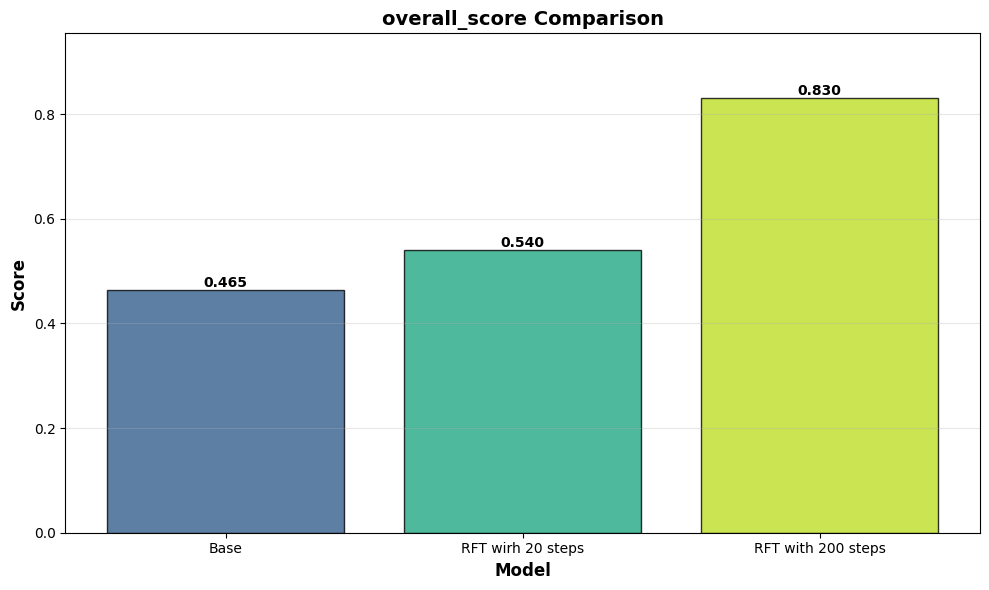

In [37]:
from utils.plots import (
    plot_model_comparison,
    plot_single_metric_comparison
)

# Create single metric comparison
fig2 = plot_single_metric_comparison(results_df, 'overall_score')
fig2.show()